In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")

In [2]:
start = timeit.default_timer()
model = pybamm.lithium_ion.BasicDFNComposite()
chemistry = pybamm.parameter_sets.Chen2020_composite
param = pybamm.ParameterValues(chemistry=chemistry)

# model = pybamm.lithium_ion.DFN()
# model = pybamm.lithium_ion.BasicDFN()
# chemistry = pybamm.parameter_sets.Chen2020
# param = pybamm.ParameterValues(chemistry=chemistry)

param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})
param.update({
    "Maximum concentration in negative electrode of phase 1 [mol.m-3]":28700,
    "Initial concentration in negative electrode of phase 1 [mol.m-3]":23000,
#     "Negative electrode mass fraction of phase 1":0.999,
#     "Negative electrode mass fraction of phase 2":0.001,
    "Initial concentration in negative electrode of phase 2 [mol.m-3]":270000,
    "Maximum concentration in negative electrode of phase 2 [mol.m-3]":278000,
#     #
#     "Maximum concentration in negative electrode of phase 1 [mol.m-3]":33133,
#     "Initial concentration in negative electrode of phase 1 [mol.m-3]":29866,
#     "Negative electrode mass fraction of phase 1":1,
#     "Negative electrode diffusivity of phase 1 [m2.s-1]":3.3E-14,
#     "Negative electrode mass fraction of phase 2":0.00,
#     "Initial concentration in negative electrode of phase 2 [mol.m-3]":275220,
#     #
    })

# initial concentration of graphite 29866 [mol.m-3]
# -> 0.934 * 25830 + 0.0866 * 275220

C_rates = 0.5
Q_cell = 5 # [Ah]
period = 1 / C_rates * Q_cell / 5
transition = period / 20
timestep=np.array([0.1, period * 4]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 0.5
        Q_cell = 5 # [Ah]
        period = 1 / C_rates * Q_cell / 5
        timestep=np.array([0.1, period * 4]) * 3600
        k = 10
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param["Current function [A]"] = I_fun(I_load)

v_si=[0.001,0.01,0.02,0.04,0.06,0.08,0.1]
solution=[]
for i in range(len(v_si)):
    param.update({
        "Negative electrode mass fraction of phase 1":1-v_si[i],
        "Negative electrode mass fraction of phase 2":v_si[i],
    })
    print(v_si[i])
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
        solver=pybamm.CasadiSolver(dt_max = 10),
    )
    solution.append(sim.solve(t_eval = t_evals))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-07-16 16:49:52,839 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model


0.001


2021-07-16 16:49:54,621 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-07-16 16:49:54,782 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-07-16 16:49:59,842 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 16:49:59,863 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 16:49:59,909 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 16:50:01,004 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.545929 and h = 1.1605e-12, the corrector convergence failed repeatedly or with |h| = hmin.
2021-07-16 16:50:09,557 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-07-16 16:50:09,558 - [INFO] base_solver.solve(811): Set-up time: 1.127 s, Solve time: 8.166 s (of which integration time: 4.084 s

0.01


2021-07-16 16:50:09,826 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-07-16 16:50:09,829 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-07-16 16:50:10,531 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 16:50:10,532 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 16:50:10,535 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 16:50:10,761 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.597908 and h = 1.54035e-12, the corrector convergence failed repeatedly or with |h| = hmin.
2021-07-16 16:50:16,359 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-07-16 16:50:16,359 - [INFO] base_solver.solve(811): Set-up time: 227.737 ms, Solve time: 5.210 s (of which integration time: 2.7

0.02


2021-07-16 16:50:17,278 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 16:50:17,278 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 16:50:17,281 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 16:50:17,451 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.653414 and h = 3.22745e-13, the corrector convergence failed repeatedly or with |h| = hmin.
2021-07-16 16:50:23,306 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-07-16 16:50:23,307 - [INFO] base_solver.solve(811): Set-up time: 173.386 ms, Solve time: 5.460 s (of which integration time: 3.173 s), Total time: 5.633 s
2021-07-16 16:50:23,316 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-07-16 16:50:23,486 - [INFO] parameter_values.process_model(501): Finish setting pa

0.04


2021-07-16 16:50:24,248 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 16:50:24,249 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 16:50:24,252 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 16:50:24,470 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-07-16 16:50:29,620 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-07-16 16:50:29,621 - [INFO] base_solver.solve(811): Set-up time: 219.800 ms, Solve time: 4.670 s (of which integration time: 2.684 s), Total time: 4.890 s
2021-07-16 16:50:29,633 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model


0.06


2021-07-16 16:50:30,305 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-07-16 16:50:30,308 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-07-16 16:50:31,599 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 16:50:31,601 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 16:50:31,604 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 16:50:31,765 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tou

0.08


2021-07-16 17:02:16,630 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-07-16 17:02:17,746 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 17:02:17,749 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 17:02:17,754 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 17:02:18,123 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At 

0.1


2021-07-16 17:20:42,571 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-07-16 17:20:42,574 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-07-16 17:20:43,910 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-07-16 17:20:43,911 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-07-16 17:20:43,915 - [INFO] base_solver.set_up(140): Start solver set-up
2021-07-16 17:20:44,471 - [INFO] base_solver.set_up(426): Finish solver set-up
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tout.
At t = 0.800543, , mxstep steps taken before reaching tou

running time: 2913.4700310000007s


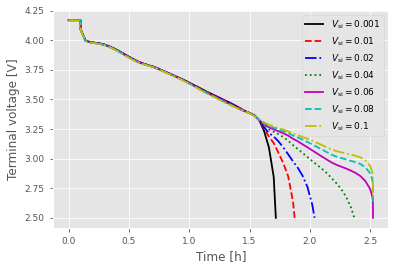

In [3]:
ltype=['k-','r--','b-.','g:','m-','c--','y-.'];
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Terminal voltage [V]"].entries
    plt.plot(t_i, V_i,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

Text(0.5, 1.0, 'Silicon')

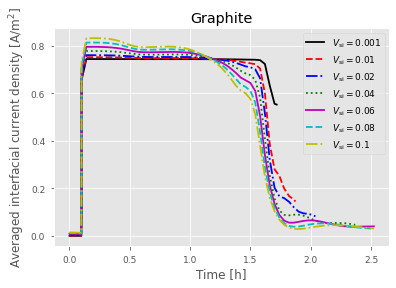

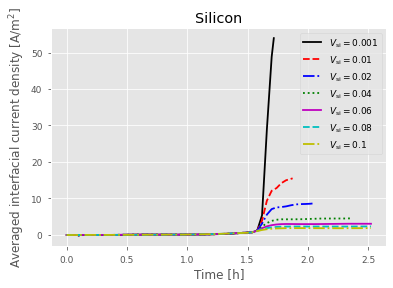

In [4]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_av = solution[i]["X-averaged negative electrode interfacial current density of phase 1 [A.m-2]"].entries
    plt.plot(t_i, j_n_p1_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_av = solution[i]["X-averaged negative electrode interfacial current density of phase 2 [A.m-2]"].entries
    plt.plot(t_i, j_n_p2_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Silicon')

Text(0.5, 1.0, 'Silicon')

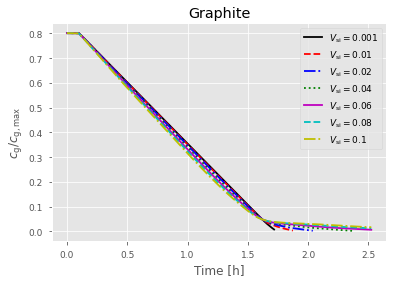

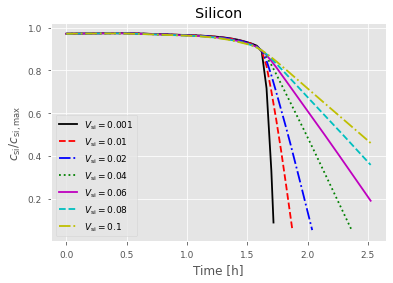

In [5]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p1 = solution[i]["Averaged negative electrode concentration of phase 1"].entries
    plt.plot(t_i, c_s_xrav_n_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{g}/c_\mathrm{g,max}$")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p2 = solution[i]["Averaged negative electrode concentration of phase 2"].entries
    plt.plot(t_i, c_s_xrav_n_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{si}/c_\mathrm{si,max}$")
plt.legend()
plt.title('Silicon')

Text(0.5, 1.0, 'NMC811')

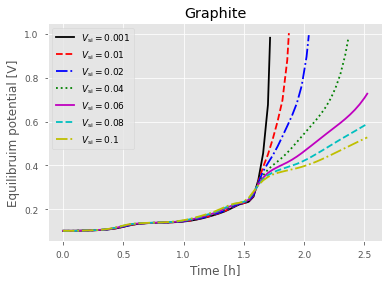

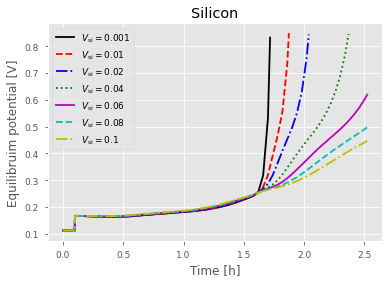

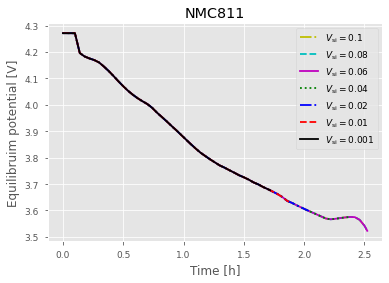

In [6]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p1 = solution[i]["X-averaged negative electrode open circuit potential of phase 1 [V]"].entries
    plt.plot(t_i, ocp_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p2 = solution[i]["X-averaged negative electrode open circuit potential of phase 2 [V]"].entries
    plt.plot(t_i, ocp_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Silicon')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[len(v_si)- 1 - i]["Time [s]"].entries / 3600
    ocp_p = solution[len(v_si)- 1 - i]["X-averaged positive electrode open circuit potential [V]"].entries
    plt.plot(t_i, ocp_p,ltype[len(v_si)- 1 - i],label="$V_\mathrm{si}=$"+str(v_si[len(v_si)- 1 - i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('NMC811')

In [7]:
return

SyntaxError: 'return' outside function (<ipython-input-7-9b32c1431b19>, line 1)

In [ ]:
x0 = np.linspace(0.025, 1, num=20)
v0 = [105,160]
ltype1=['k-','r-','b-','g-','m-','c-','y-'];
ltype2=['k:','r:','b:','g:','m:','c:','y:'];

for j in range(0,len(v0)):
    plt.figure()
    for i in range(0,len(v_si)):
        t_i = solution[i]["Time [s]"].entries / 3600
        c_s_n_p1 = solution[i]["Negative electrode concentration of phase 1"].entries
        c_s_n_p2 = solution[i]["Negative electrode concentration of phase 2"].entries
        c_s_rav_n_p1 = solution[i]["R-averaged negative particle concentration of phase 1"].entries
        c_s_rav_n_p2 = solution[i]["R-averaged negative particle concentration of phase 2"].entries
        vj=v0[j]
        if vj > len(t_i)-1:
            vj = len(t_i)-1

        err1=c_s_n_p1[0,:,vj]-c_s_rav_n_p1[:,vj]
        err2=c_s_rav_n_p1[:,vj]-c_s_n_p1[-1,:,vj]
        plt.errorbar(x0, c_s_rav_n_p1[:,vj],yerr=[err2,err1],fmt=ltype1[i],label='$V_\mathrm{si}=$'+str(v_si[i]),capsize=3)

        err1=c_s_n_p2[0,:,vj]-c_s_rav_n_p2[:,vj]
        err2=c_s_rav_n_p2[:,vj]-c_s_n_p2[-1,:,vj]
        plt.errorbar(x0, c_s_rav_n_p2[:,vj],yerr=[err2,err1],fmt=ltype2[i],label='$V_\mathrm{si}=$'+str(v_si[i]),capsize=1.5)

    plt.xlabel("$x_n$")
    plt.ylabel("Normalised Li concentration")
    plt.annotate('Current collector', xy=(0, 1.05), xycoords='data', xytext=(0.12, 1.05), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    plt.annotate('Separator', xy=(1, 1.05), xycoords='data', xytext=(0.72, 1.05), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    # plt.annotate('Current collector',(0.1,5),)  

    plt.ylim([-0.05, 1.1])
    # plt.xlim([96, 102])
    plt.title('$t$='+str(np.round(t_i[vj],decimals=2))+' h for '+str(C_rates)+" C discharge")
plt.text(-0.15,-0.32,'Graphite') 
plt.text(-0.13,-0.42,'Silicon') 
plt.legend(ncol=7, loc = (0.05,-0.35))

In [ ]:
x0 = np.linspace(0.025, 1, num=20)
v0 = [105,142]
ltype1=['k-','r-','b-','g-','m-','c-','y-'];
ltype2=['k:','r:','b:','g:','m:','c:','y:'];

for j in range(0,len(v0)):
    plt.figure()
    for i in range(0,len(v_si)):
        t_i = solution[i]["Time [s]"].entries / 3600
        ocp_n_p1 = solution[i]["Negative electrode open circuit potential of phase 1 [V]"].entries
        ocp_n_p2 = solution[i]["Negative electrode open circuit potential of phase 2 [V]"].entries
        vj=v0[j]
        if vj > len(t_i)-1:
            vj = len(t_i)-1

        plt.plot(x0, ocp_n_p1[:,vj],ltype1[i],label='$V_\mathrm{si}=$'+str(v_si[i]))
        plt.plot(x0, ocp_n_p2[:,vj],ltype2[i],label='$V_\mathrm{si}=$'+str(v_si[i]))

    plt.xlabel("$x_n$")
    plt.ylabel("Equilibruim potential [V]")
    plt.annotate('Current collector', xy=(0.15, 0.3), xycoords='figure fraction', xytext=(0.25, 0.3), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    plt.annotate('Separator', xy=(0.92, 0.3), xycoords='figure fraction', xytext=(0.68, 0.3), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    # plt.annotate('Current collector',(0.1,5),)  

    # plt.ylim([-0.05, 1.1])
    # plt.xlim([96, 102])
    plt.title('$t$='+str(np.round(t_i[vj],decimals=2))+' h for '+str(C_rates)+" C discharge")
plt.text(-0.15,-0.32,'Graphite') 
plt.text(-0.13,-0.42,'Silicon') 
plt.legend(ncol=7, loc = (0.05,-0.35))

In [ ]:
for i in range(0,7):
    print(solution[i]["Time [s]"].entries / 3600)
print(len(solution[6]["Time [s]"].entries))